# Detection of synchronization artifact in EEG recordings

In [1]:
import sys
import os

# Get the path to the project root (one level up from the notebook)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root, NOT 'source', to sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# print the sys.path
print(sys.path)

import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import plotly.graph_objects as go

from source.sync_artefact_finder import detect_sync_from_eeg


['/Users/lenasalzmann/dev/dbs-eeg-sync', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/lenasalzmann/dev/dbs-eeg-sync/.venv/lib/python3.12/site-packages']


EEG data cropped to 120.0 seconds.


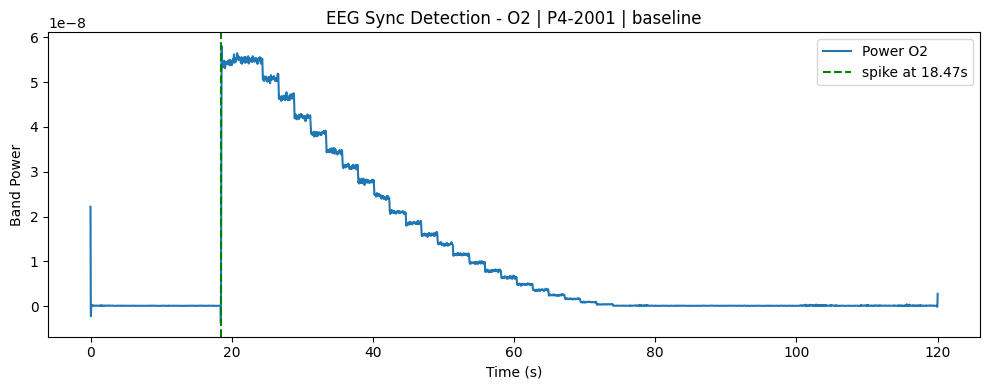

EEG data cropped to 120.0 seconds.


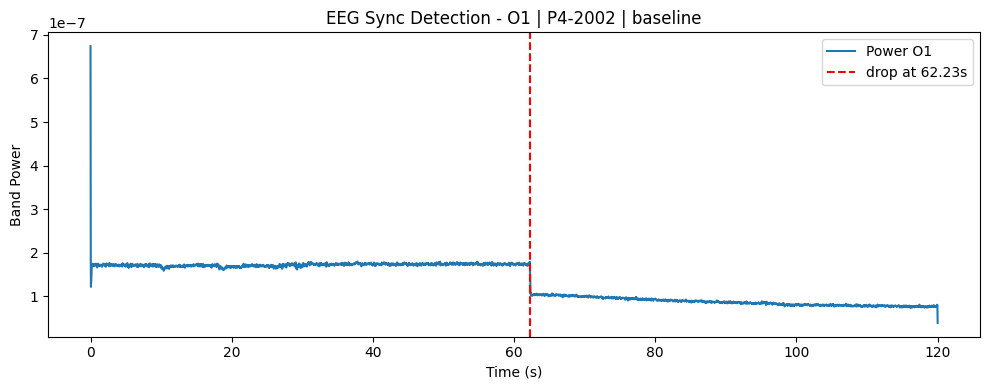

EEG data cropped to 120.0 seconds.


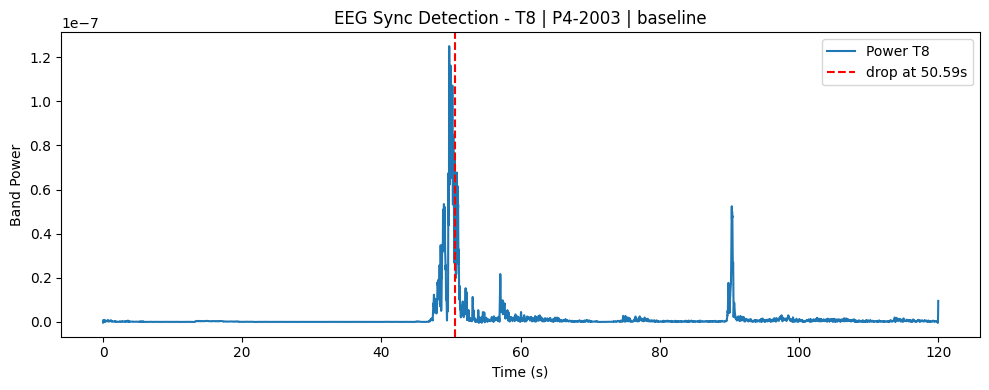

EEG data cropped to 120.0 seconds.


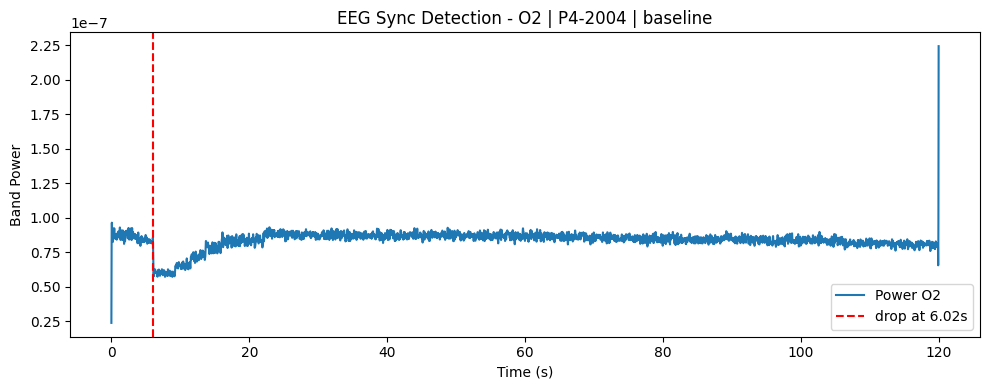

EEG data cropped to 120.0 seconds.


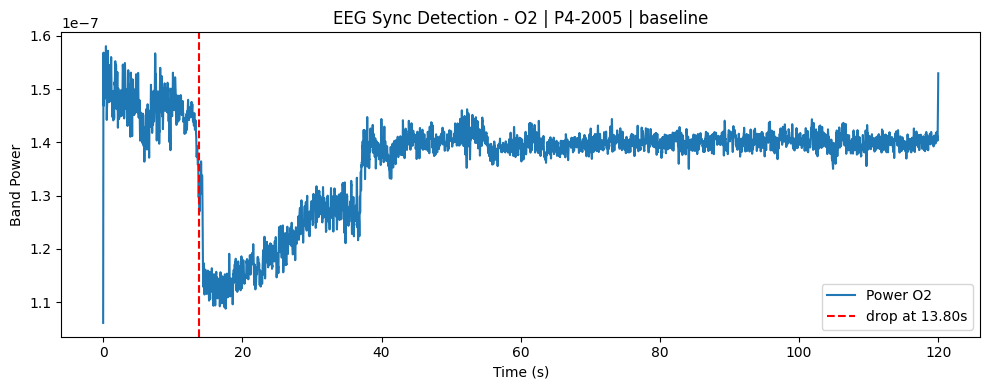

EEG data cropped to 120.0 seconds.


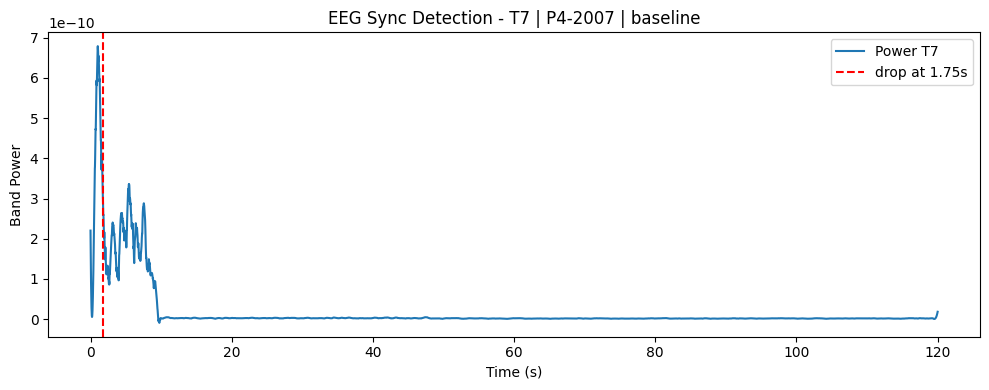

EEG data cropped to 120.0 seconds.


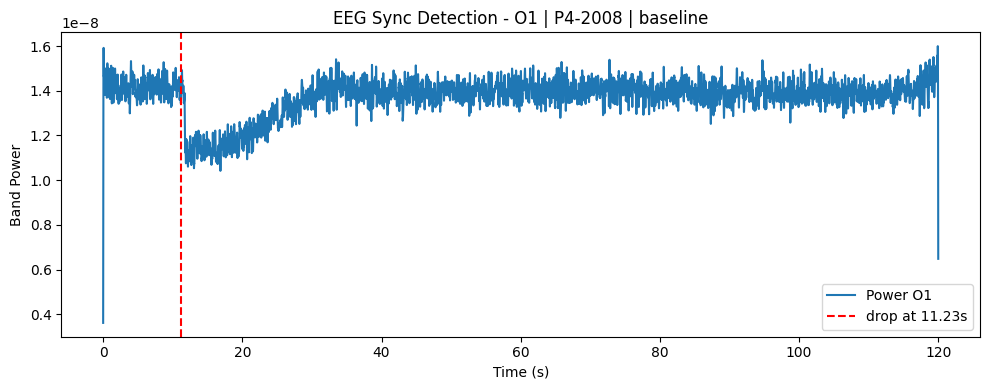

EEG data cropped to 120.0 seconds.


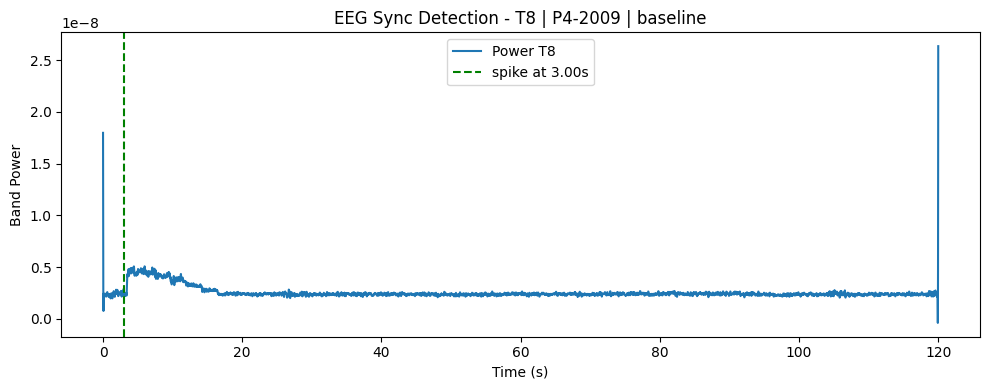

EEG data cropped to 120.0 seconds.


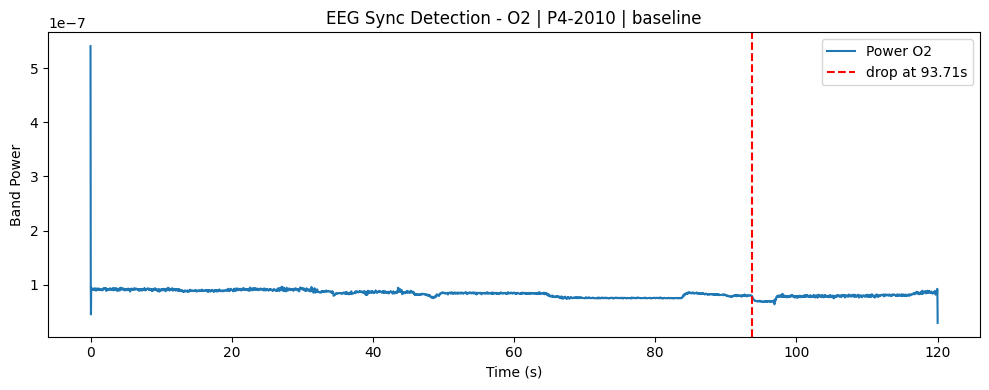

EEG data cropped to 120.0 seconds.


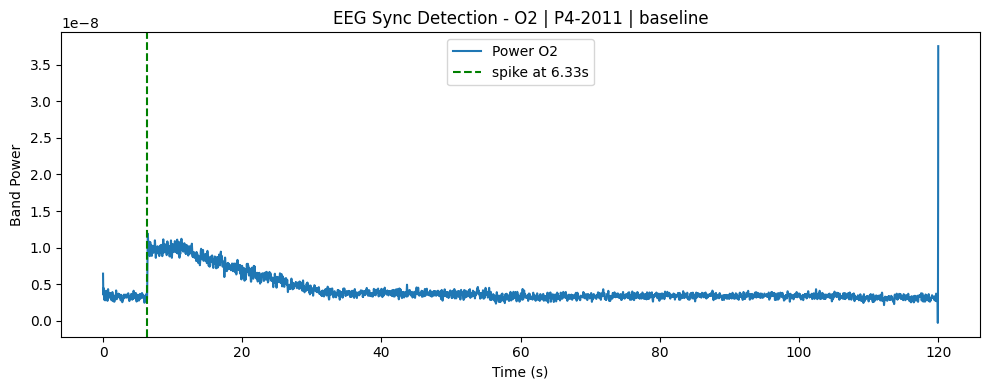

EEG data cropped to 120.0 seconds.


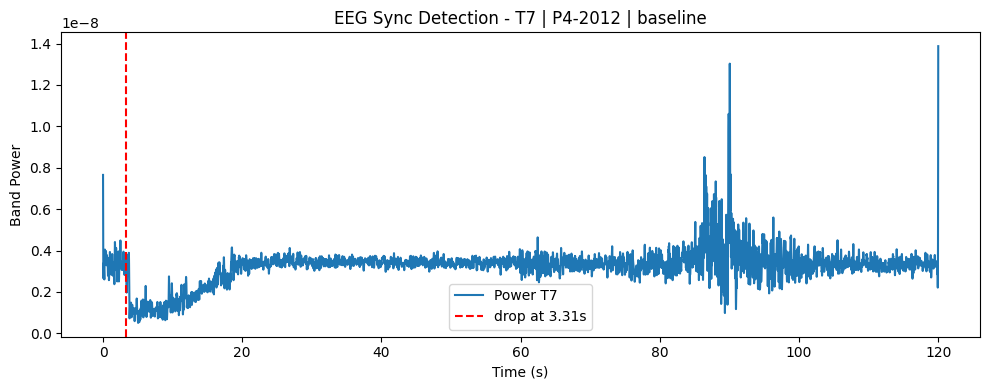

In [2]:
# run for all patients
sub_ids = [ 'P4-2001', 'P4-2002', 'P4-2003', 'P4-2004', 'P4-2005', 'P4-2007', 'P4-2008', 'P4-2009', 'P4-2010', 'P4-2011', 'P4-2012']
# sub_id = 'P4-2001'
block = 'baseline'
dataDir_server = r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB"


# loop through sub_ids
for sub_id in sub_ids:
    eeg_file = os.path.join(dataDir_server, sub_id, 'RawData', 'EEG', block, block + '_raw.set')
    eeg_data = mne.io.read_raw_eeglab(eeg_file, preload=True)
    if sub_id == 'P4-2007':
        freq_low, freq_high = 110, 120
    else:
        freq_low, freq_high = 120, 130

    channel, eeg_sync_idx, eeg_sync_s, result, smoothed_power = detect_sync_from_eeg(eeg_data, freq_low=freq_low, freq_high=freq_high, time_range=(0,120), plot=True, save_dir='outputs/plots', sub_id=sub_id, block=block)

EEG data cropped to 120.0 seconds.


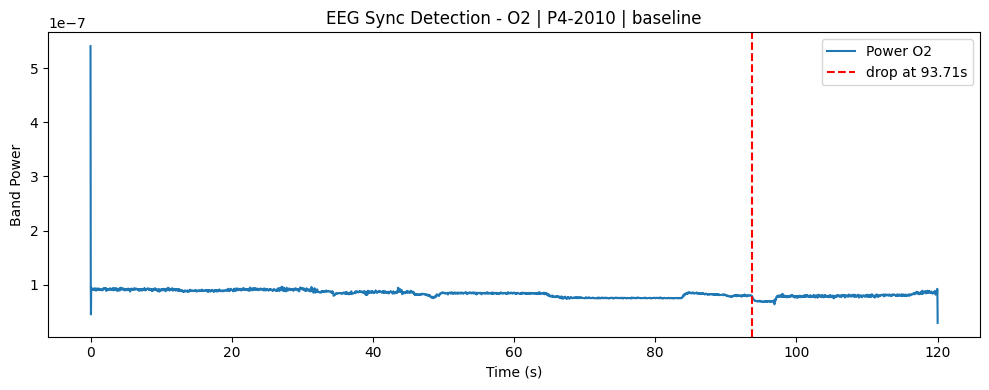

No selection made, user closed the window without saving.


In [3]:
from source.slider import run_manual_sync_slider

sub_id = 'P4-2010'
block = 'baseline'
freq_low, freq_high = 120, 130

eeg_file = os.path.join(dataDir_server, sub_id, 'RawData', 'EEG', block, block + '_raw.set')
eeg_data = mne.io.read_raw_eeglab(eeg_file, preload=True)

_, _, _, _, smoothed_power_pat = detect_sync_from_eeg(eeg_data, freq_low=freq_low, freq_high=freq_high, time_range=(0,120), plot=True, save_dir=None, sub_id=sub_id, block=block)
selected_eeg_index = run_manual_sync_slider(pd.DataFrame(smoothed_power_pat), sub_id, block)

# Investigate the faulty trials

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'AFz', 'Fz', 'Cz', 'Pz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'FT9', 'FT10', 'TP7', 'TP8', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP9', 'TP10', 'PO7', 'PO8', 'PO9', 'PO10', 'CPz', 'POz', 'AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'QuatW', 'QuatX', 'QuatY', 'QuatZ']
EEG data cropped to 175.3 seconds.


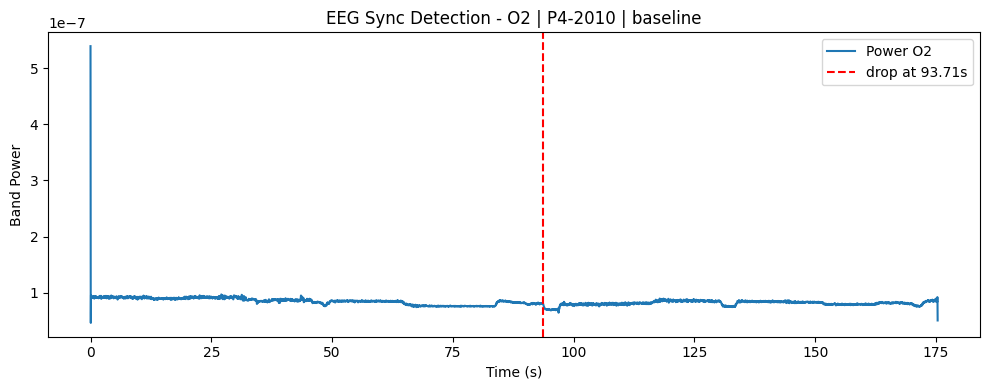

In [4]:
sub_id = 'P4-2010'
block = 'baseline'
dataDir_server = r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB"


# loop through sub_ids
eeg_file = os.path.join(dataDir_server, sub_id, 'RawData', 'EEG', block, block + '_raw.set')
eeg_data = mne.io.read_raw_eeglab(eeg_file, preload=True)
freq_low, freq_high = 120, 130
if sub_id == 'P4-2007':
    freq_low, freq_high = 110, 120

print(eeg_data.ch_names)

channel, eeg_sync_idx, eeg_sync_s, result, smoothed_power  = detect_sync_from_eeg(eeg_data, freq_low=freq_low, freq_high=freq_high, plot=True, save_dir=None, sub_id=sub_id, block=block)